# Model calibration

Kendra Wyant  
June 11, 2025

### Set Up Environment

In [ ]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))
suppressPackageStartupMessages(library(tidymodels))

path_models <- format_path("risk/models/lag")

options(knitr.kable.NA = '')

### Read in best model predicitons

In [ ]:
preds_0 <- read_rds(here::here(path_models, "final_preds_kfold_1_x_5_1day_0_v3_strat_lh_final.rds"))
preds_336 <- read_rds(here::here(path_models, "final_preds_kfold_1_x_5_1day_336_v3_strat_lh_final.rds"))

### Plots

In [ ]:
bin_width = 0.10

preds_all_raw <- preds_0 |> 
  mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  mutate(model = "No lag") |> 
  bind_rows(preds_336 |> 
              mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)), 
                     lapse = if_else(label == "Lapse", 1, 0)) |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("No lag",  "2 weeks")))

preds_all_logi <- preds_0 |> 
  mutate(bins = cut(prob_logi, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  mutate(model = "No lag") |> 
  bind_rows(preds_336 |> 
              mutate(bins = cut(prob_logi, breaks = seq(0, 1, bin_width)), 
                     lapse = if_else(label == "Lapse", 1, 0)) |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("No lag",  "2 weeks")))

preds_all_beta <- preds_0 |> 
  mutate(bins = cut(prob_beta, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  mutate(model = "No lag") |>  
  bind_rows(preds_336 |> 
              mutate(bins = cut(prob_beta, breaks = seq(0, 1, bin_width)), 
                     lapse = if_else(label == "Lapse", 1, 0)) |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("No lag", "2 weeks")))

preds_all_iso <- preds_0 |> 
  mutate(prob_iso = if_else(prob_iso == 0, .0000000001, prob_iso)) |>  
  mutate(bins = cut(prob_iso, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  mutate(model = "No lag") |>  
  bind_rows(preds_336 |> 
              mutate(prob_iso = if_else(prob_iso == 0, .0000000001, prob_iso)) |>  
              mutate(bins = cut(prob_iso, breaks = seq(0, 1, bin_width)), 
                     lapse = if_else(label == "Lapse", 1, 0)) |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("No lag", "2 weeks")))

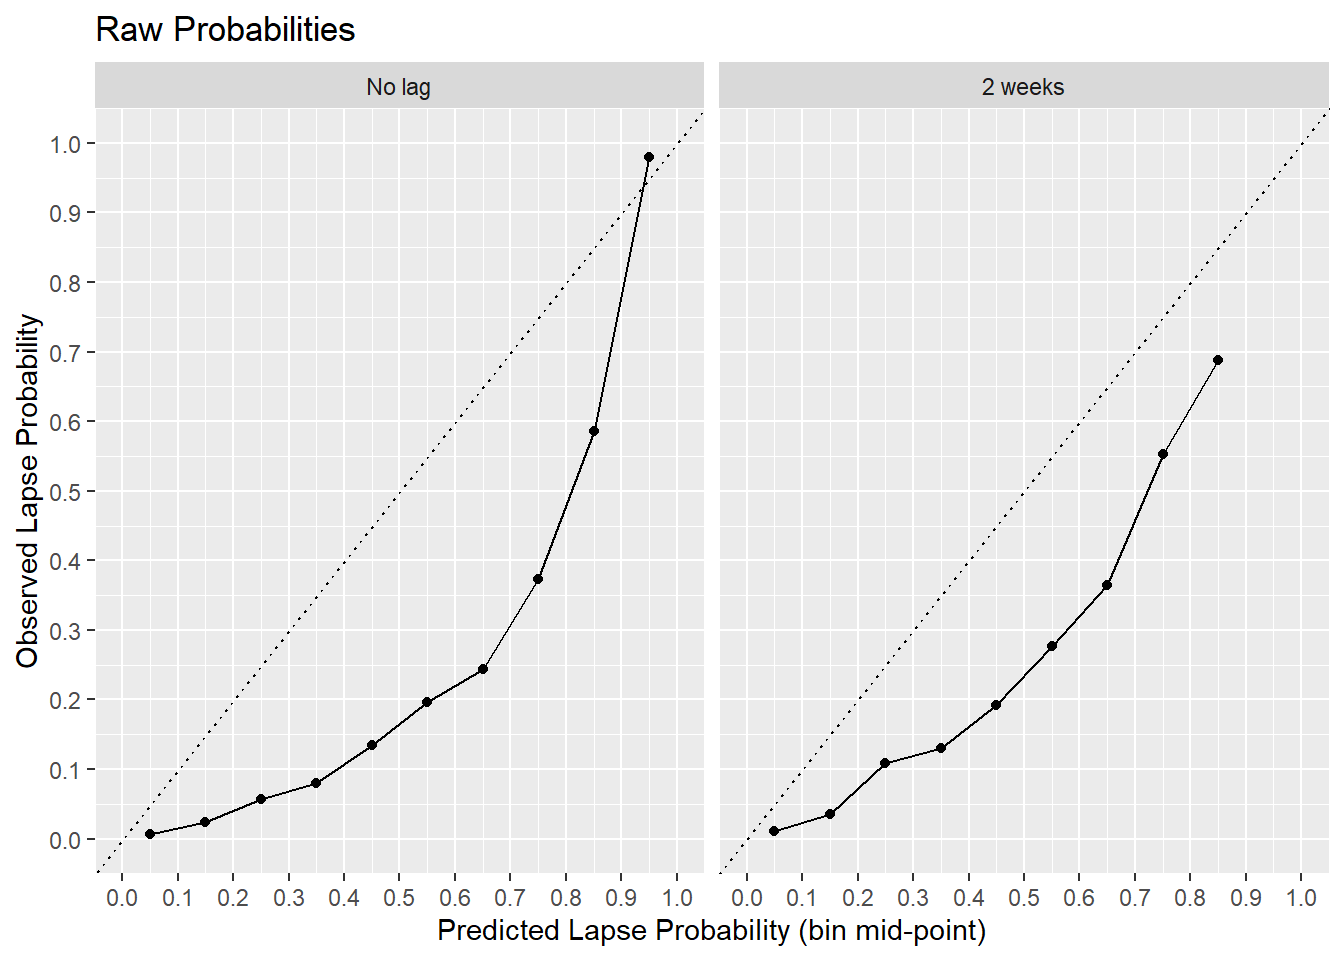

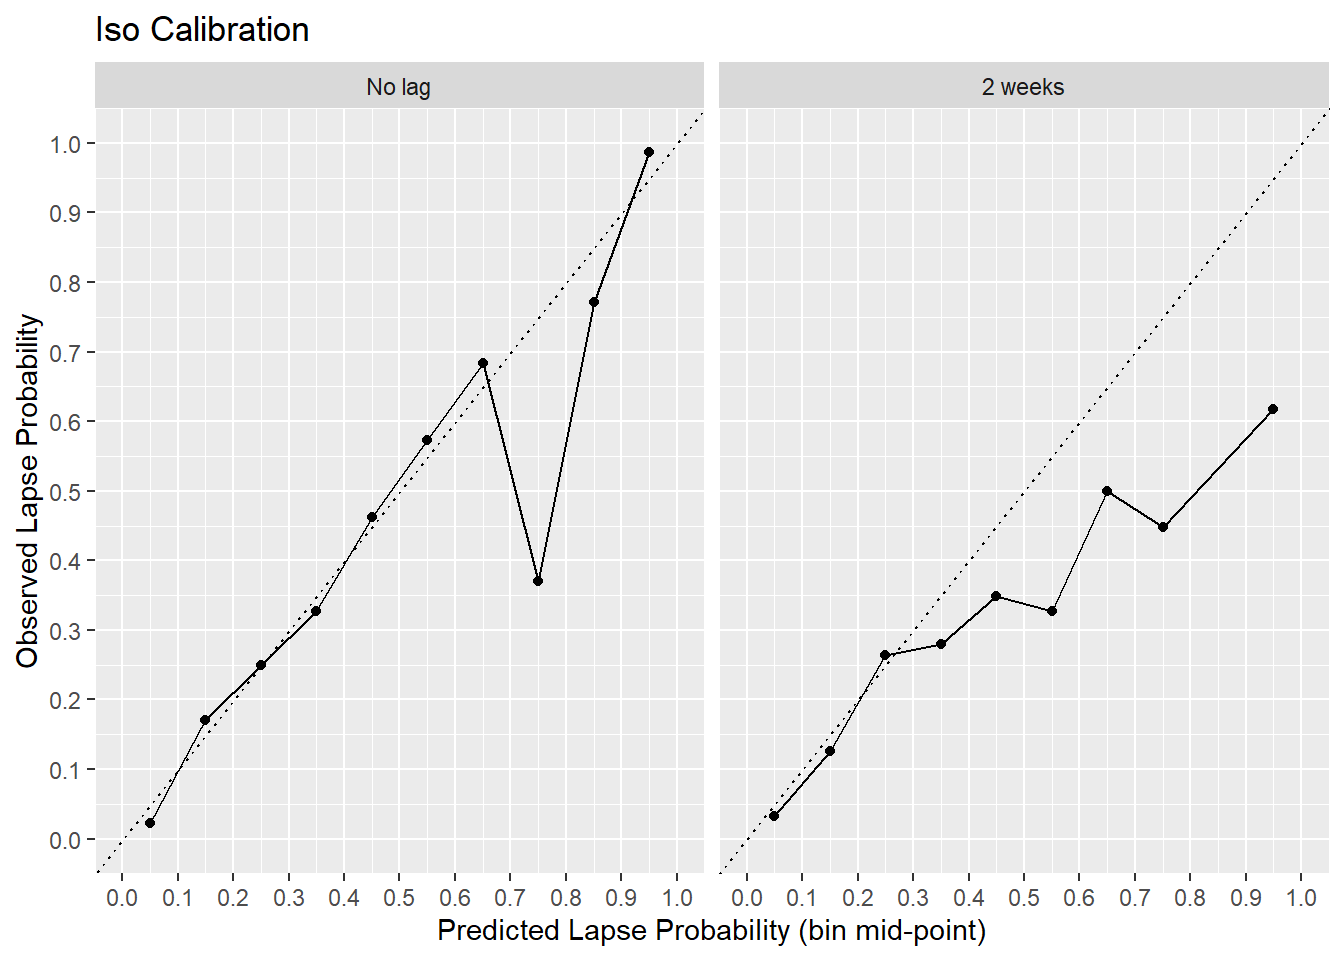

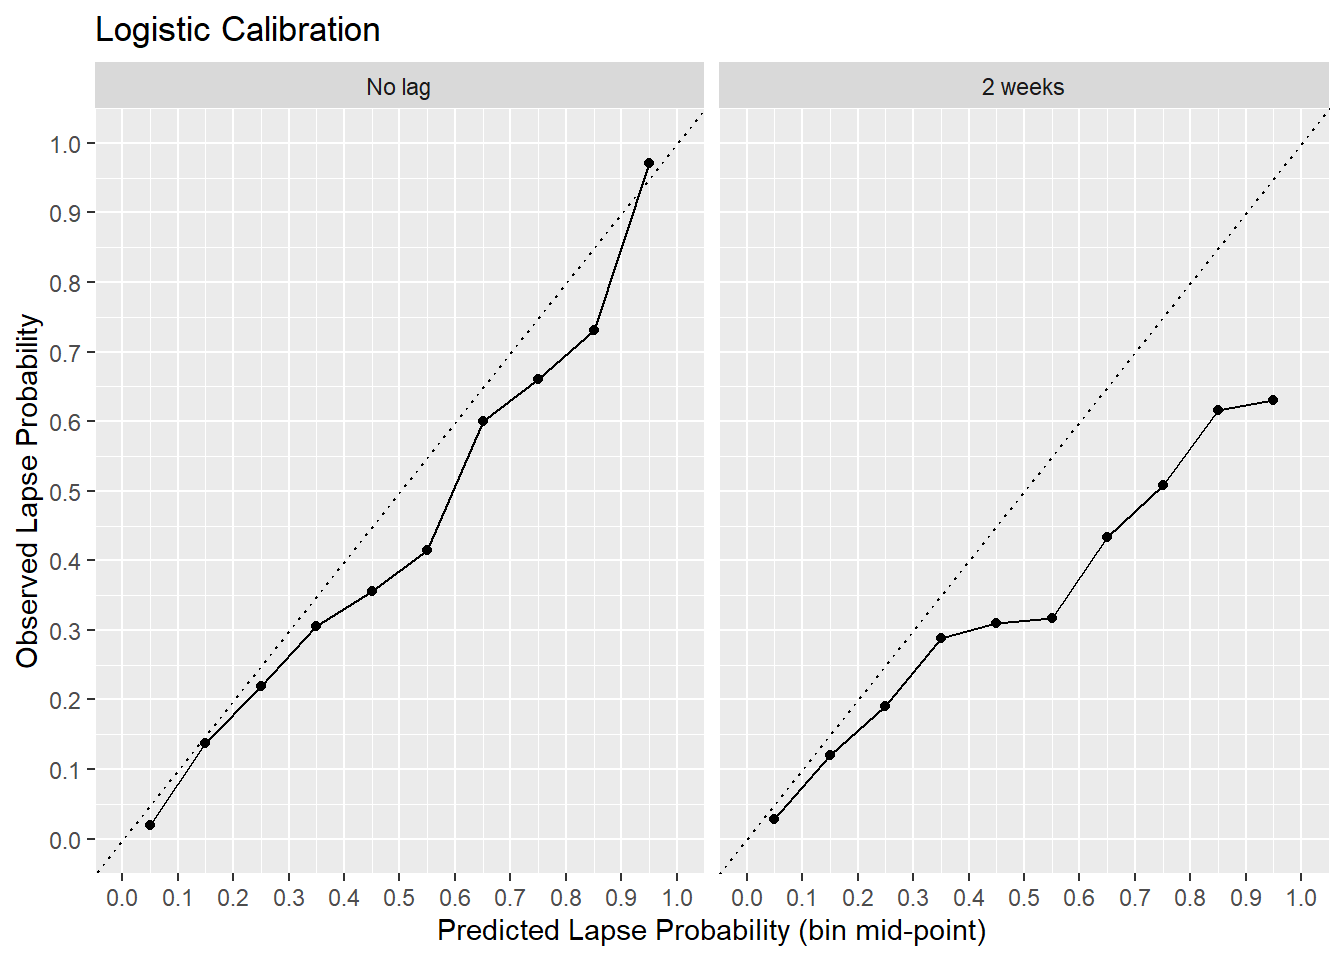

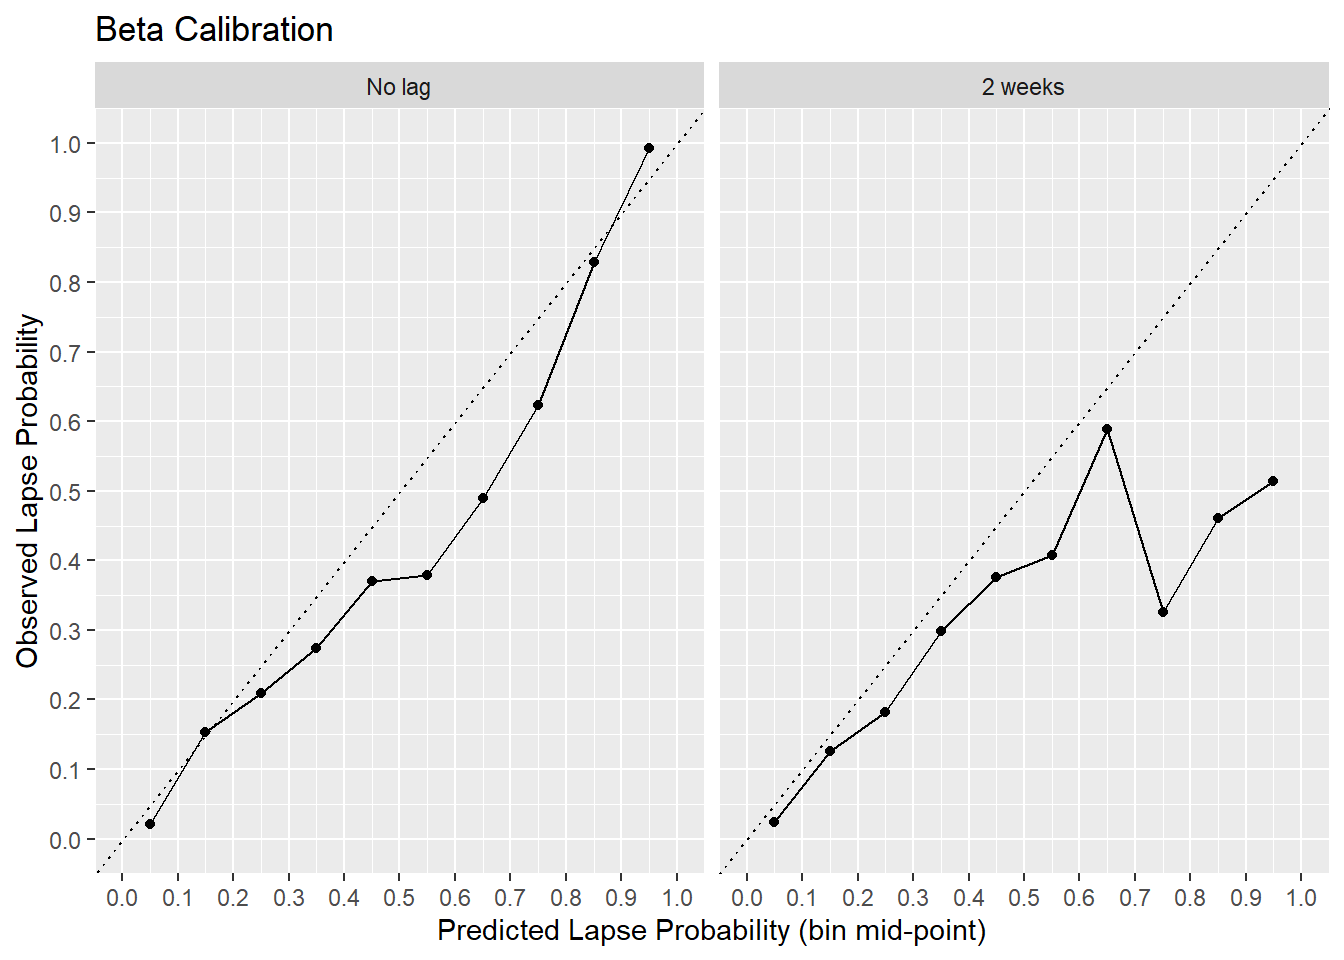

In [ ]:
preds_all_raw |> 
  group_by(bins, model)  |> 
  summarize(mean_lapse = mean(lapse),
            .groups = "drop") |> 
  mutate(bins = as.numeric(bins),
         midpoints = bin_width/2 + bin_width * (bins - 1))  |> 
  ggplot(data = _, aes(x = midpoints, y = mean_lapse)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  geom_line() +
  geom_point() +
  facet_wrap(~ model) +
  labs(x = "Predicted Lapse Probability (bin mid-point)",
       y = "Observed Lapse Probability",
       title = "Raw Probabilities") +
  scale_x_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) 

### Brier Scores

Base rates of lapses

In [ ]:
mean(preds_336$label == "Lapse") 

[1] 0.07649943

Raw probabilities

In [ ]:
brier_class(preds_0, truth = label, prob_raw)

# A tibble: 1 × 3
  .metric     .estimator .estimate
  <chr>       <chr>          <dbl>
1 brier_class binary        0.0705

# A tibble: 1 × 3
  .metric     .estimator .estimate
  <chr>       <chr>          <dbl>
1 brier_class binary        0.0767

[1] 0.07359727

Iso

In [ ]:
brier_class(preds_0, truth = label, prob_iso)

# A tibble: 1 × 3
  .metric     .estimator .estimate
  <chr>       <chr>          <dbl>
1 brier_class binary        0.0427

# A tibble: 1 × 3
  .metric     .estimator .estimate
  <chr>       <chr>          <dbl>
1 brier_class binary        0.0616

[1] 0.0521402

Logi

In [ ]:
brier_class(preds_0, truth = label, prob_logi)

# A tibble: 1 × 3
  .metric     .estimator .estimate
  <chr>       <chr>          <dbl>
1 brier_class binary        0.0425

# A tibble: 1 × 3
  .metric     .estimator .estimate
  <chr>       <chr>          <dbl>
1 brier_class binary        0.0627

[1] 0.05261502

Beta

In [ ]:
brier_class(preds_0, truth = label, prob_beta)

# A tibble: 1 × 3
  .metric     .estimator .estimate
  <chr>       <chr>          <dbl>
1 brier_class binary        0.0426

# A tibble: 1 × 3
  .metric     .estimator .estimate
  <chr>       <chr>          <dbl>
1 brier_class binary        0.0608

[1] 0.05171503

Relative improvement of beta calibration compared to raw

In [ ]:
(brier_class(preds_0, truth = label, prob_raw)$.estimate - 
  brier_class(preds_0, truth = label, prob_beta)$.estimate) / 
  brier_class(preds_0, truth = label, prob_raw)$.estimate

[1] 0.3958183

[1] 0.2067182